# How Does a Neural Network Really Work?

In [1]:
from fastai.basics import *

In [2]:
# A function which will plot a graph of a given function
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None, text=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if text: plt.text(1.25, -1, text)
    if title is not None: plt.title(title)

## Reducing Error

In [3]:
from ipywidgets import interact # Used for sliders to alter constants
import numpy as np

An AI model tries to minimise error by adjusting parameters so that it the loss (difference between true and guesses value) is minimal. This is known as gradient descent. Below is an example of manually adjusting the values of a, b, c (in $y = ax^2 + bx + c$) to minimise the loss.

In [4]:
### Create a quadratic function
def quad(a, b, c, x): return a*x**2 + b*x + c # Create a function which produces a quadratic

def mk_quad(a, b, c): # A function where a, b, c are fixed, but x can still be changed
    return lambda x: a * x**2 + b * x + c

### Creating a noisy function
x = torch.linspace(-2, 2, steps = 20)

y_clean = quad(1.7, -0.5, 1.1, x) # List x is input and produces a list of y 

torch.manual_seed(42)  
y_noise = y_clean + (torch.rand_like(y_clean) * 3 - 1.5) # Generates noise +-1.5

### Creating loss function
def rmse(pred, act): # Calculates the root mean square error from predicted and actual values
    error = pred - act
    square = error **2
    mean = square.mean()
    return mean **0.5

### Display the chart
@interact(a=1.1, b=1.1, c=1.1) # From ipywidgets, add before a function to change the specified variables
def plot_slider_quad(a,b,c):
    plt.scatter(x, y_noise)

    f = mk_quad(a, b, c)
    loss = rmse(f(x), y_clean)
    plot_function(mk_quad(a, b, c), ylim = (-2, 11), title=f'RMSE: {loss:.2f}')

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In the chart above, we must guess which way to move the slider to decrease the error. Instead of guessing, we can use the use the gradient of the error as this will tell us which way to move.

In [5]:
# Creating a function which takes parameters in a tensor and returns the rmse
def quad_rmse(params):
    f = mk_quad(*params) # the * splits the list into sepearetae inputs. e.g. [1, 2, 3] -> 1, 2, 3
    return rmse(f(x), y_noise)

In [6]:
# Creating intial inputs
parameters = torch.tensor([1.1, 1.1, 1.1]) 

# Need to call this to calculate gradients
parameters.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

In [7]:
# Calculate loss using rmse
loss = quad_rmse(parameters)
loss

tensor(2.6837, grad_fn=<PowBackward0>)

In [8]:
# Calculate the gradients for each variable
loss.backward() # Call this first
parameters.grad

tensor([-1.1115,  0.9372, -0.4829])

The tensor above states what would happen to the rmse if each variable is increased by 1 (assuming the original equation is linear (which it isn't!)).  

If positive, the variable should be reduced to reduce error.  
If negative, the variable should be increased to reduce error.  

Below, you can see the calculated gradients and how they are used to lower the rmse

In [9]:
### Display the chart
@interact(a=1.1, b=1.1, c=1.1) # From ipywidgets, add before a function to change the specified variables
def plot_slider_quad(a,b,c):
    plt.scatter(x, y_noise)

    parameters = torch.tensor([a, b, c])
    parameters.requires_grad_()
    
    f = mk_quad(a, b, c)
    
    loss = quad_rmse(parameters)
    loss.backward()
    gradient = parameters.grad

    text = f'''Gradients
    a = {gradient[0]:.4f}
    b = {gradient[1]:.4f}
    c = {gradient[2]:.4f}
    '''
    
    plot_function(mk_quad(a, b, c), ylim = (-2, 10), title=f'RMSE: {loss:.2f}', text=text)

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

# Automatic Calculation

The process above can be automated using an iterative process. After every calculation of gradients, each parameter is multiplied by the negative gradient (and a learning rate).  
The learning rate determines how quickly the model 'learns'.  

Too slow and the model will take too long  
Too fast the model will never converge

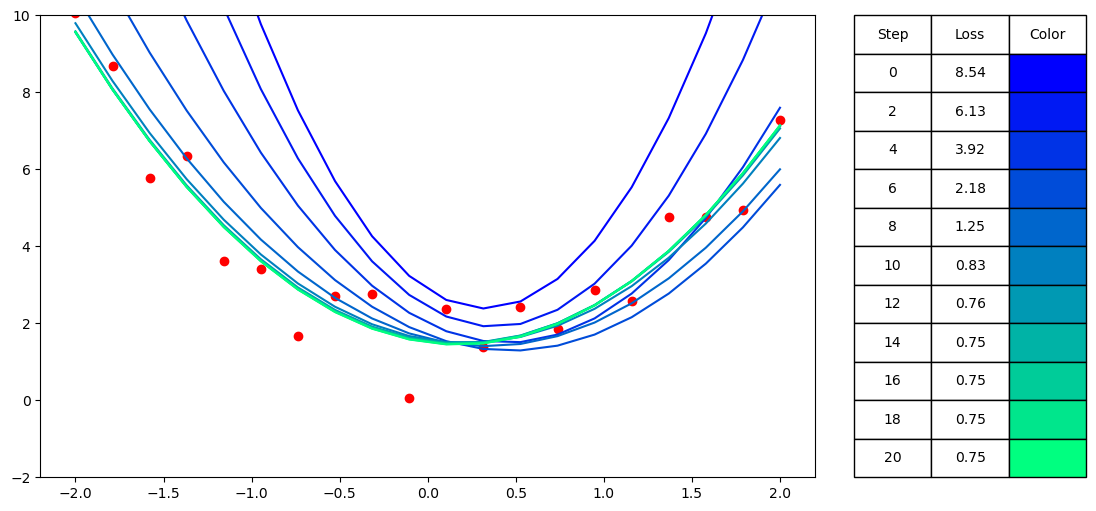

In [10]:
import matplotlib.colors as mcolors

# Initialize parameters
parameters = torch.tensor([5.1, -3.1, 3.1], requires_grad=True)
learning_rate = 0.3
steps = 21

plt.figure(figsize=(10,6))

plt.scatter(x, y_noise, facecolor='red')
plt.ylim([-2, 10])

cmap = plt.get_cmap('winter')  # Colormap
steps_to_plot = list(range(0, steps, 2))

plot_idx = 0
table_data = []
cell_colors = []

for i in range(steps):
    loss = quad_rmse(parameters)
    loss.backward()

    with torch.no_grad():
        parameters -= learning_rate * parameters.grad
        parameters.grad.zero_()

    if i in steps_to_plot:
        y_fit = mk_quad(*parameters)(x).detach()
        color = cmap(plot_idx / (len(steps_to_plot)-1))
        plt.plot(x, y_fit, color=color)
        table_data.append([f'{i}', f'{loss.item():.2f}', ''])  # text column empty
        cell_colors.append([[1,1,1], [1,1,1], color])  # RGB for cell background
        plot_idx += 1

# Add table with colored cells
columns = ['Step', 'Loss', 'Color']
plt.table(cellText=table_data, cellColours=cell_colors,
          colLabels=columns, cellLoc='center', colLoc='center',
          loc='right', bbox=[1.05, 0, 0.3, 1])

plt.show()

## Rectified Linear Equations

Lots of data cannot be modelled as quadratic functions. Instead rectified linear (Relu) functions are used, these are a linear function which are set to 0 once their value becomes negative

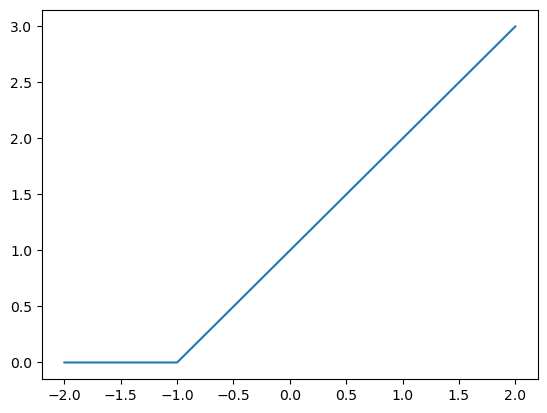

In [11]:
# Basic Relu function
def rectified_linear(m, c, x):
    y = m * x + c # A simple linear equation
    if y < 0: # However, if less than 0 = 0
        y = 0
    return y

x = list(range(-2, 3))
y = []
for xi in x:
    y.append(rectified_linear(1, 1, xi))
plt.plot(x, y)
plt.show()

In [12]:
# Using pytorch so that it can handle tensors
# Also using interact to play with sliders
def relu(m,b,x): # Can deal with a list of x
    y = m*x+b
    return torch.clip(y, 0.) # If y is less than 0, it will be 'clipped' to 0

@interact(m=1.1, b=1.1)
def plot_relu(m, b): 
    plot_function(partial(relu, m,b), ylim=(-1, 4))

interactive(children=(FloatSlider(value=1.1, description='m', max=3.3000000000000003, min=-1.1), FloatSlider(v…

Multiple relu functions are added together to generate more complicated functions

In [13]:
def quad_relu(m1, b1, m2, b2, m3, b3, m4, b4, x):
    return (
        relu(m1, b1, x)
        + relu(m2, b2, x)
        + relu(m3, b3, x)
        + relu(m4, b4, x)
    )

@interact(m1=1.1, b1=-1.1, m2=-2.1, b2=-1.1, m3=2.1, b3=0.1, m4=-1.1, b4=1.1)
def plot_quad_relu(m1, b1, m2, b2, m3, b3, m4, b4):
    plot_function(partial(quad_relu, m1,b1,m2,b2,m3,b3,m4,b4), ylim=(-1,10))

interactive(children=(FloatSlider(value=1.1, description='m1', max=3.3000000000000003, min=-1.1), FloatSlider(…

# Automating Relu Function Optimisation

In [14]:
def inf_relu(params, x):
    y = torch.zeros_like(x, dtype=torch.float)
    for i in range(0, len(params), 2):
        m = params[i]
        b = params[i+1]
        y += relu(m, b, x)
    return y
   
def inf_relu_rmse(params):
    def f(x):
        y = torch.zeros_like(x, dtype=torch.float)
        for i in range(0, len(params), 2):
            m = params[i]
            b = params[i+1]
            y += relu(m, b, x)
        return y
    
    return rmse(f(x), y_noise)

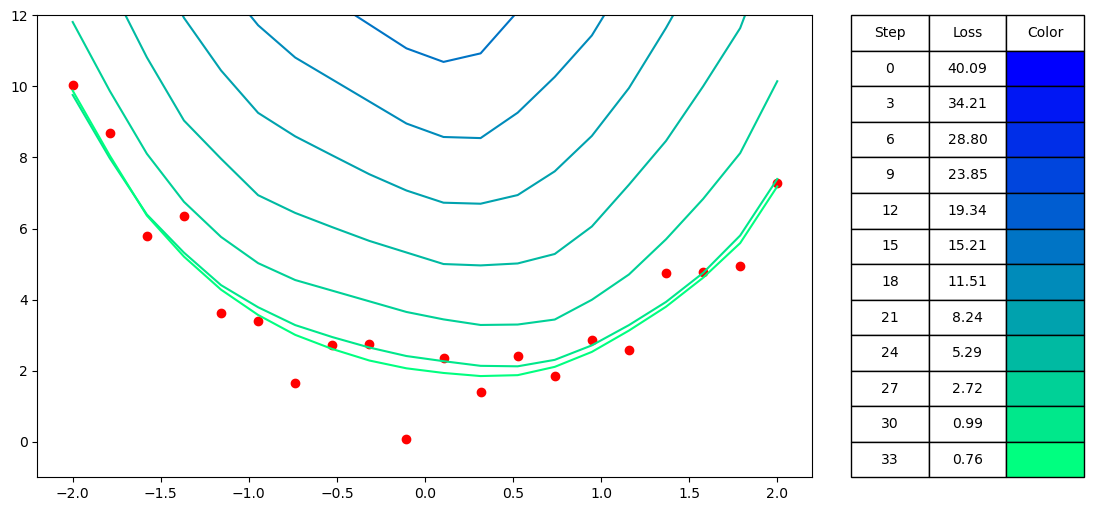

In [38]:
# Initialize data
x = torch.linspace(-2, 2, steps=20)
learning_rate = 0.075
steps = 36

torch.manual_seed(42)
parameters = (torch.rand(100) * 5 - 2.5).requires_grad_()  # alter the number of relu functions
parameters.requires_grad_()

plt.figure(figsize=(10,6))
plt.scatter(x.detach().numpy(), y_noise.detach().numpy(), facecolor='red')
plt.ylim([-1, 12])

cmap = plt.get_cmap('winter')
steps_to_plot = list(range(0, steps, 3))

plot_idx = 0
table_data = []
cell_colors = []

for i in range(steps):
    loss = inf_relu_rmse(parameters)
    loss.backward()
    
    with torch.no_grad():
        parameters -= learning_rate * parameters.grad
        parameters.grad.zero_()
    
    if i in steps_to_plot:
        y_fit = inf_relu(parameters, x).detach()
        color = cmap(plot_idx / (len(steps_to_plot)-1))
        plt.plot(x.detach().numpy(), y_fit.numpy(), color=color)
        
        # Table data
        table_data.append([f'{i}', f'{loss.item():.2f}', ''])
        cell_colors.append([[1,1,1], [1,1,1], color])
        
        plot_idx += 1

# Add table next to plot
columns = ['Step', 'Loss', 'Color']
plt.table(cellText=table_data, cellColours=cell_colors,
          colLabels=columns, cellLoc='center', colLoc='center',
          loc='right', bbox=[1.05, 0, 0.3, 1])

plt.show()